# Exercises


# Q1

`Try to build a classifier for the MNIST dataset that achieves over 97%
accuracy on the test set. Hint: the KNeighborsClassifier works quite well
for this task; you just need to find good hyperparameter values (try a
grid search on the weights and n_neighbors hyperparameters).`


In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.ndimage import shift
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)

In [3]:
X, y = mnist.data, mnist.target
X[:5], y[:5]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
 array(['5', '0', '4', '1', '9'], dtype=object))

In [4]:
# Split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
preprocessing = make_pipeline(StandardScaler())

In [11]:
knn_clf = make_pipeline(preprocessing, KNeighborsClassifier())
knn_clf.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler())])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [12]:
cross_val_score(knn_clf, X_train, y_train, cv=3, scoring="accuracy")
# acc is good but we have to boost this to 97

array([0.9377 , 0.94125, 0.942  ])

In [16]:
acc = knn_clf.score(X_test, y_test)
acc

0.9443

In [14]:
knn_clf1 = KNeighborsClassifier()
knn_clf1.fit(X_train, y_train)
cross_val_score(knn_clf1, X_train, y_train, cv=3, scoring="accuracy")
# without scaling we are getting better results

array([0.9676 , 0.9671 , 0.96755])

In [17]:
acc1 = knn_clf1.score(X_test, y_test)
acc1

0.9688

In [20]:
param_grid = [{"weights": ["uniform", "distance"], "n_neighbors": [3, 4, 5, 6, 7]}]
knn_clf_cv = KNeighborsClassifier()

grid_search = GridSearchCV(knn_clf_cv, param_grid, cv=6)
grid_search.fit(X_train[:20000], y_train[:20000])

GridSearchCV(cv=6, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6, 7],
                          'weights': ['uniform', 'distance']}])

In [21]:
grid_search.best_score_
# and this only on a part of sample not full sample so it was expected

0.9573996991780763

In [22]:
grid_search.best_estimator_.fit(X_train, y_train)
acc_cv = grid_search.score(X_test, y_test)
acc_cv

0.9714

# Q2

`Write a function that can shift an MNIST image in any direction (left,
right, up, or down) by one pixel. Then, for each image in the training
set, create four shifted copies (one per direction) and add them to the
training set. Finally, train your best model on this expanded training set
and measure its accuracy on the test set. You should observe that your
model performs even better now! This technique of artificially growing
the training set is called data augmentation or training set expansion.`


In [27]:
def shift_image(
    image, dx, dy
):  # dx Dy are directions x and y... like how much u want to shift in either
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

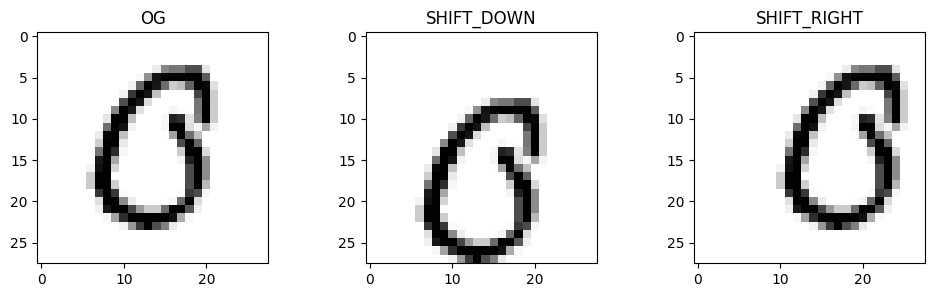

In [30]:
# checking
image = X[234]

shifted_down = shift_image(image, 0, 4)
shifted_right = shift_image(image, 4, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("OG")
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.subplot(132)
plt.title("SHIFT_DOWN")
plt.imshow(shifted_down.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.subplot(133)
plt.title("SHIFT_RIGHT")
plt.imshow(shifted_right.reshape(28, 28), interpolation="nearest", cmap="Greys")

In [33]:
# now doing data augmentation
X_train_aug = [image for image in X_train]
y_train_aug = [label for label in y_train]

for dx, dy in ((-1, 0), (0, 1), (1, 0), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_aug.append(shift_image(image, dx, dy))
        y_train_aug.append((label))

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

In [35]:
X_train_aug.shape, y_train_aug.shape

((300000, 784), (300000,))

In [36]:
# shuffling the dataset
shuffle_idx = np.random.permutation(len(X_train_aug))
X_train_aug = X_train_aug[shuffle_idx]
y_train_aug = y_train_aug[shuffle_idx]

In [37]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

knn_clf.fit(X_train_aug, y_train_aug)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [38]:
aug_acc = knn_clf.score(X_test, y_test)

In [39]:
aug_acc

0.9763

In [43]:
boost = abs(acc_cv - aug_acc)
boost
# this 0.5% boost signifies that error rate is dropped

0.004899999999999904

In [44]:
error_rate_change = (1 - aug_acc) / (1 - acc_cv) - 1

error_rate_change * 100
# gone down by 17%

-17.132867132866824

# Q3

`Tackle the Titanic dataset. A great place to start is on Kaggle.
Alternatively, you can download the data from
https://homl.info/titanic.tgz and unzip this tarball like you did for the
housing data in Chapter 2. This will give you two CSV files, train.csv
and test.csv, which you can load using pandas.read_csv(). The goal is to
train a classifier that can predict the Survived column based on the other
columns`


In [2]:
import sys
import os

script_path = r"C:\Users\whate\OneDrive\Desktop\ML,Excell and Kaggle\Scirpts"

sys.path.append(script_path)

In [24]:
from Tarball_download import download_extract_tarball

In [4]:
path = download_extract_tarball(
    url="https://homl.info/titanic.tgz", extract_path="datasets"
)

titanic.tgz downloaded successfully.
Extracting titanic.tgz...
Extracted to datasets.
titanic.tgz removed after extraction.


The attributes have the following meaning:

- **PassengerId**: a unique identifier for each passenger
- **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
- **Pclass**: passenger class.
- **Name**, **Sex**, **Age**: self-explanatory
- **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
- **Parch**: how many children & parents of the passenger aboard the Titanic.
- **Ticket**: ticket id
- **Fare**: price paid (in pounds)
- **Cabin**: passenger's cabin number
- **Embarked**: where the passenger embarked the Titanic


In [9]:
titanic_tr_df = pd.read_csv("datasets/titanic/train.csv")
titanic_tr_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
titanic_ts_df = pd.read_csv("datasets/titanic/test.csv")
titanic_ts_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [7]:
# setting test set aside.... visualising the training set

titanic_tr_df.describe()  # evudent that age has some missing values

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
titanic_tr_df.count()  # cabin also has some missing values and so does embarked

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [10]:
# setting up a index
## Passenger ID is a unique value accros both datasets

titanic_tr_df = titanic_tr_df.set_index("PassengerId")
titanic_ts_df = titanic_ts_df.set_index("PassengerId")

In [11]:
titanic_tr_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [12]:
titanic_tr_df.describe()  # Passenger Id has been converted to index

# by reading mean we can see Age is less than 30... survival rate is 38%(as values were only zero,one)

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Pipeline building


In [14]:
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [16]:
cat_pipeline = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    OneHotEncoder(sparse_output=False),
)

In [18]:
num_attribs = titanic_tr_df.select_dtypes(include=["number"]).columns.tolist()
cat_attribs = titanic_tr_df.select_dtypes(
    include=["object", "category"]
).columns.tolist()

In [19]:
num_attribs, cat_attribs

(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'],
 ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'])

In [20]:
num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Sex", "Embarked", "Pclass"]

preprocessing_pipeline = ColumnTransformer(
    [("num", num_pipeline, num_attribs), ("cat", cat_pipeline, cat_attribs)]
)

In [21]:
X_train = preprocessing_pipeline.fit_transform(titanic_tr_df)
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ]])

In [22]:
y_train = titanic_tr_df["Survived"]

# Data Prepared now training


In [27]:
# First let's try RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [28]:
rf.score(X_train, y_train)

0.9797979797979798

In [29]:
X_test = preprocessing_pipeline.fit_transform(titanic_ts_df)
y_pred = rf.predict(X_test)

In [30]:
rf_score = cross_val_score(rf, X_train, y_train, cv=10)
rf_score.mean()

0.8159925093632958